In [38]:
# Libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

#load the data
#YYYY-MM-DD
df = pd.read_csv('../nyc_data.csv')
df

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...,...
2187,12/27/2020,685.915026,0,0,0,2.89,38.674
2188,12/28/2020,998.051170,0,0,0,8.83,166.712
2189,12/29/2020,847.123399,0,0,0,3.48,161.865
2190,12/30/2020,857.521043,0,0,0,5.97,179.634


In [2]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305


In [3]:
# Date variable
df.ds = pd.to_datetime(df.ds,
               format  = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2187   2020-12-27
2188   2020-12-28
2189   2020-12-29
2190   2020-12-30
2191   2020-12-31
Name: ds, Length: 2192, dtype: datetime64[ns]

# Holidays

In [4]:
# Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({"holiday": "easter",
                       "ds": dates,
                       "lower_window": -5,
                       "upper_window": 2})

In [5]:
# Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({"holiday": "thanksgiving",
                       "ds": dates,
                       "lower_window": -3,
                       "upper_window": 6})

In [6]:
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [7]:
# Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [8]:
df = df.drop(["Easter", "Thanksgiving"], axis = 1)

In [9]:
df.head(0)

,ds,y,Christmas,Temperature,Marketing


In [10]:
m = Prophet(holidays = holidays,
            seasonality_mode= 'multiplicative',
            seasonality_prior_scale= 10,
            holidays_prior_scale= 10,
            changepoint_prior_scale= 0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(df)

17:09:50 - cmdstanpy - INFO - Chain [1] start processing
17:09:51 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Check how many observations we have
df.shape[0] - 180

2012

In [16]:
# Cross validation
df_cv = cross_validation(m,
                         horizon= '31 days',
                         period= '16 days',
                         initial= '2012 days',
                         parallel= 'processes')
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.823846,538.754050,677.226417,571.069531,2020-07-09
1,2020-07-11,722.779284,657.880793,789.152796,677.106981,2020-07-09
2,2020-07-12,637.633736,571.307593,702.897327,619.572774,2020-07-09
3,2020-07-13,769.994975,707.833601,839.075019,808.932621,2020-07-09
4,2020-07-14,637.272765,572.892420,705.662966,661.791644,2020-07-09


In [19]:
# Performance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2825.852482,53.158748,43.391823,0.058998,0.063697,0.060112,0.767742
1,5 days,2815.268196,53.059101,44.416247,0.062093,0.064770,0.062913,0.767742
2,6 days,3528.006036,59.397020,50.621529,0.069963,0.064770,0.071403,0.703226
3,7 days,2814.378966,53.050721,42.829469,0.060352,0.059589,0.061418,0.732258
4,8 days,2759.882080,52.534580,40.281218,0.055642,0.056726,0.057152,0.735484


In [37]:
# RMSE and MAPE
print(f"RMSE: ", round(performance_metrics(df_cv)["rmse"].mean(), 1))
print(f"RMSE: ", 100 * round(performance_metrics(df_cv)["mape"].mean(), 3), "%")



RMSE:  53.6
RMSE:  5.800000000000001 %


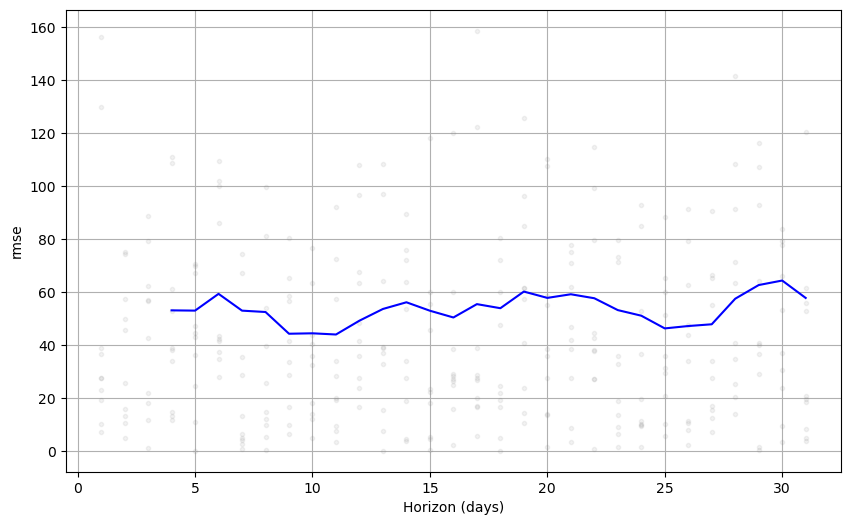

In [40]:
# Is there an increase in error over time?  (is the forecast less reliable as time goes by?)
plot_cross_validation_metric(df_cv, metric= 'rmse');